In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

from scipy.ndimage import gaussian_filter1d

import math

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [95]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [199]:
# sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup\*.csv')
sessions = glob.glob(r'D:\projects\ripple_heterogeneity\swr_seq_isi_deep_sup\*.csv')

# df = pd.read_csv(sessions[1])

In [360]:
class ISI_analysis:
    def __init__(self, xmin=0, xmax=100):
        self.xmin = xmin
        self.xmax = xmax

    def area(self):
        return self.xmin * self.xmax

    def test(self,x,y,z=1):
        return x+y+z

isi = ISI_analysis()
isi.area()

isi.test(3,2)

        

6

In [361]:
class ISI_analysis:
    def __init__(self, xmin=0, xmax=100,binwidth=0.001,ripple_freq=1/200):
        self.xmin = xmin
        self.xmax = xmax
        self.binwidth = binwidth
        self.ripple_freq = ripple_freq

    def bin_data(self,data,xmin=0,xmax=0.100,binwidth=0.001):
        bins = np.arange(xmin,xmax+binwidth,binwidth)

        hist, _ = np.histogram(data,bins=bins)
        hist = hist/hist.sum()
        return hist

    def peak_cycle_time(self,isi,cycle_num=1):

        bin_center = np.arange(self.xmin,self.xmax,self.binwidth) + self.binwidth
        idx = (bin_center >= self.ripple_freq*(cycle_num-1)) & (bin_center <= self.ripple_freq*cycle_num)

        cycle_ts = bin_center[idx]

        return cycle_ts[np.argmax(isi[idx])]

    def peak_cycle_val(self,isi,cycle_num=1):

        bin_center = np.arange(self.xmin,self.xmax,self.binwidth) + self.binwidth
        idx = (bin_center >= self.ripple_freq*(cycle_num-1)) & (bin_center <= self.ripple_freq*cycle_num)

        return np.max(isi[idx])

isi = ISI_analysis()

mean_isi = np.zeros((len(sessions),3))
peak_ts_first_cycle = np.zeros_like(mean_isi)
peak_ts_second_cycle = np.zeros_like(mean_isi)
peak_val_first_cycle = np.zeros_like(mean_isi)
peak_val_second_cycle = np.zeros_like(mean_isi)
peak_val_norm_first_cycle = np.zeros_like(mean_isi)
peak_val_norm_second_cycle = np.zeros_like(mean_isi)

all_deep_isi = np.zeros((len(sessions),100))
all_sup_isi = np.zeros((len(sessions),100))
all_deep_sup_isi = np.zeros((len(sessions),100))

for i,basepath in enumerate(sessions):
    # print(basepath)
    isi_df = pd.read_csv(basepath)

    # mean isi
    mean_isi[i,:] = [np.mean(isi_df.Deep),
                    np.mean(isi_df.Superficial),
                    np.mean(isi_df.DeepSuperficial)]

    # make ISI dist
    deep_isi = isi.bin_data(isi_df.Deep)
    sup_isi = isi.bin_data(isi_df.Superficial)
    deep_sup_isi = isi.bin_data(isi_df.DeepSuperficial)
    
    # store isi
    all_deep_isi[i,:] = deep_isi
    all_sup_isi[i,:] = sup_isi
    all_deep_sup_isi[i,:] = deep_sup_isi

    # max ts of first peak
    peak_ts_first_cycle[i,:] = [isi.peak_cycle_time(deep_isi),
                            isi.peak_cycle_time(sup_isi),
                            isi.peak_cycle_time(deep_sup_isi)]
    # max ts of second peak
    peak_ts_second_cycle[i,:] = [isi.peak_cycle_time(deep_isi,cycle_num=2),
                                isi.peak_cycle_time(sup_isi,cycle_num=2),
                                isi.peak_cycle_time(deep_sup_isi,cycle_num=2)]

    # max of first peak
    peak_val_first_cycle[i,:] = [isi.peak_cycle_val(deep_isi),
                                isi.peak_cycle_val(sup_isi),
                                isi.peak_cycle_val(deep_sup_isi)]
    # max of second peak
    peak_val_second_cycle[i,:] = [isi.peak_cycle_val(deep_isi,cycle_num=2),
                                isi.peak_cycle_val(sup_isi,cycle_num=2),
                                isi.peak_cycle_val(deep_sup_isi,cycle_num=2)]

    # max of first peak normed
    peak_val_norm_first_cycle[i,:] = [isi.peak_cycle_val(deep_isi - gaussian_filter1d(deep_isi, 5)),
                                isi.peak_cycle_val(sup_isi - gaussian_filter1d(sup_isi, 5)),
                                isi.peak_cycle_val(deep_sup_isi - gaussian_filter1d(deep_sup_isi, 5))]
    # max of second peak normed
    peak_val_norm_second_cycle[i,:] = [isi.peak_cycle_val(deep_isi - gaussian_filter1d(deep_isi, 5),cycle_num=2),
                                isi.peak_cycle_val(sup_isi - gaussian_filter1d(sup_isi, 5),cycle_num=2),
                                isi.peak_cycle_val(deep_sup_isi - gaussian_filter1d(deep_sup_isi, 5),cycle_num=2)]    


                                    # sigma = 5
    # first_peak_ts[np.argmax(deep_isi[idx])
    # gaussian_filter1d(deep_isi, sigma)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 100000

In [316]:
df = pd.DataFrame()
df['ca1_layer'] = ["deep"]*len(mean_isi[:,0]) + ["sup"]*len(mean_isi[:,0]) + ["deep_sup"]*len(mean_isi[:,0])
df['mean_isi'] = np.hstack([mean_isi[:,0],mean_isi[:,1],mean_isi[:,2]])
df['peak_ts_first_cycle'] = np.hstack([peak_ts_first_cycle[:,0],peak_ts_first_cycle[:,1],peak_ts_first_cycle[:,2]])
df['peak_ts_second_cycle'] = np.hstack([peak_ts_second_cycle[:,0],peak_ts_second_cycle[:,1],peak_ts_second_cycle[:,2]])
df['peak_val_first_cycle'] = np.hstack([peak_val_first_cycle[:,0],peak_val_first_cycle[:,1],peak_val_first_cycle[:,2]])
df['peak_val_second_cycle'] = np.hstack([peak_val_second_cycle[:,0],peak_val_second_cycle[:,1],peak_val_second_cycle[:,2]])
df['peak_val_norm_first_cycle'] = np.hstack([peak_val_norm_first_cycle[:,0],peak_val_norm_first_cycle[:,1],peak_val_norm_first_cycle[:,2]])
df['peak_val_norm_second_cycle'] = np.hstack([peak_val_norm_second_cycle[:,0],peak_val_norm_second_cycle[:,1],peak_val_norm_second_cycle[:,2]])
df

,ca1_layer,mean_isi,peak_ts_first_cycle,peak_ts_second_cycle,peak_val_first_cycle,peak_val_second_cycle,peak_val_norm_first_cycle,peak_val_norm_second_cycle
0,deep,0.035195,0.001,0.005,0.022540,0.022019,0.000583,0.000503
1,deep,0.041769,0.002,0.006,0.018791,0.018030,0.001375,0.000913
2,deep,0.035887,0.001,0.006,0.024780,0.023461,0.001955,0.001738
3,deep,0.038922,0.001,0.007,0.022644,0.020892,0.002061,0.001017
4,deep,0.039112,0.002,0.007,0.021705,0.020980,0.001515,0.001357
...,...,...,...,...,...,...,...,...
358,deep_sup,0.053269,0.003,0.006,0.018330,0.019746,0.000263,0.001810
359,deep_sup,0.042952,0.003,0.007,0.024312,0.022260,0.004947,0.002234
360,deep_sup,0.051339,0.003,0.006,0.017666,0.017464,0.002095,0.001609
361,deep_sup,0.051883,0.003,0.007,0.020125,0.020593,0.001944,0.002202


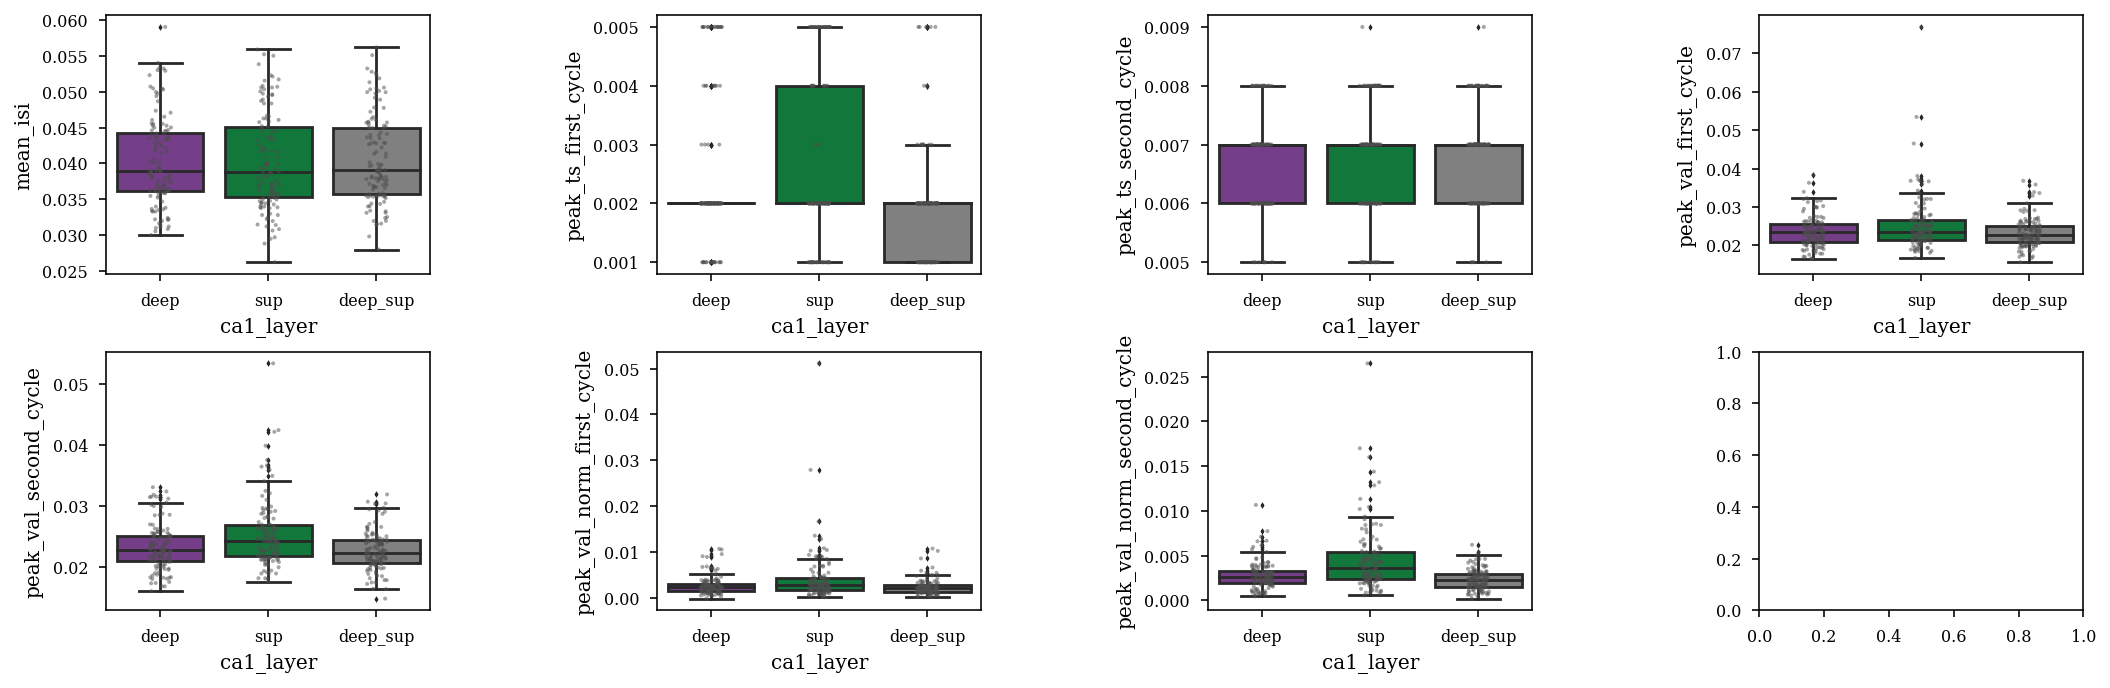

In [334]:
import seaborn as sns
def plot_the_box(df,x,y,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,
                 ax=ax,hue_order=group_colors.keys())

    sns.stripplot(x=x, y=y, data=df,
                size=2, color=".3", linewidth=0,ax=ax,
                alpha=.5,dodge=True,hue_order=group_colors.keys())


fig, axs = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=3, subplots=(2, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors= {"deep": '#7b3294',
                'sup': '#008837',
                'deep_sup': "grey"
                } 

sns.set_palette(sns.color_palette(group_colors.values()))

plot_the_box(df,"ca1_layer","mean_isi",group_colors,axs[0])
plot_the_box(df,"ca1_layer","peak_ts_first_cycle",group_colors,axs[1])
plot_the_box(df,"ca1_layer","peak_ts_second_cycle",group_colors,axs[2])

plot_the_box(df,"ca1_layer","peak_val_first_cycle",group_colors,axs[3])

plot_the_box(df,"ca1_layer","peak_val_second_cycle",group_colors,axs[4])
plot_the_box(df,"ca1_layer","peak_val_norm_first_cycle",group_colors,axs[5])
plot_the_box(df,"ca1_layer","peak_val_norm_second_cycle",group_colors,axs[6])


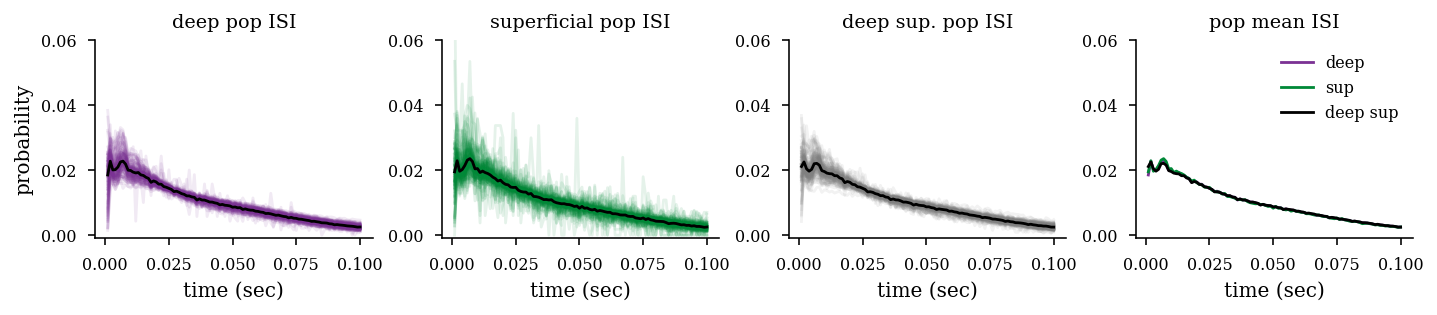

In [297]:
fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=2, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.25)
axs = axs.ravel()

xmin=0
xmax=0.100
binwidth=0.001
bin_center = np.arange(xmin,xmax,binwidth) + binwidth

axs[0].plot(bin_center,all_deep_isi.T,color="#7b3294",alpha=.1)
axs[0].plot(bin_center,np.mean(all_deep_isi,axis=0),color="k")

axs[1].plot(bin_center,all_sup_isi.T,color="#008837",alpha=.1)
axs[1].plot(bin_center,np.mean(all_sup_isi,axis=0),color="k")

axs[2].plot(bin_center,all_deep_sup_isi.T,color="grey",alpha=.1)
axs[2].plot(bin_center,np.mean(all_deep_sup_isi,axis=0),color="k")

axs[3].plot(bin_center,np.mean(all_deep_isi,axis=0),color="#7b3294",label="deep")
axs[3].plot(bin_center,np.mean(all_sup_isi,axis=0),color="#008837",label="sup")
axs[3].plot(bin_center,np.mean(all_deep_sup_isi,axis=0),color="k",label="deep sup")

axs[0].set_ylabel('probability')

axs[0].set_title('deep pop ISI')
axs[1].set_title('superficial pop ISI')
axs[2].set_title('deep sup. pop ISI')
axs[3].set_title('pop mean ISI')

axs[3].legend(frameon=False)

for i in range(4):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_xlabel('time (sec)')
    axs[i].set_ylim(-.001,0.06)

plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_mean_example.pdf'),dpi=300,bbox_inches='tight')



In [231]:
print(max_cycle(deep_isi - gaussian_filter1d(deep_isi, 5)))

max_cycle(deep_isi)

0.003


0.003

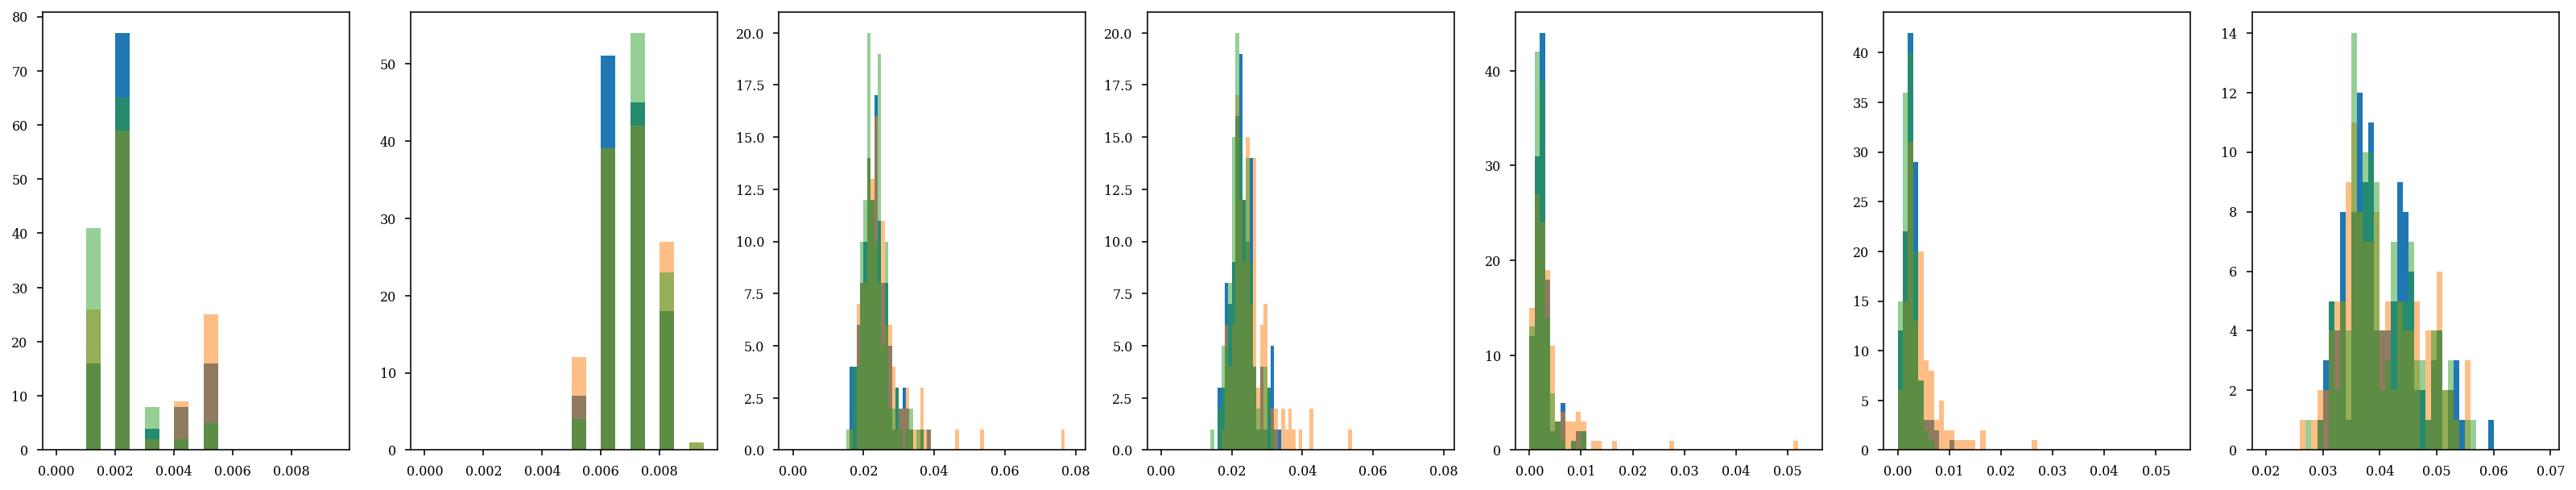

In [256]:
plt.figure(figsize=(28,5))
plt.subplot(171)
bins=np.arange(0,.01,.0005)
plt.hist(peak_ts_first_cycle[:,0],bins=bins)
plt.hist(peak_ts_first_cycle[:,1],bins=bins,alpha=.5)
plt.hist(peak_ts_first_cycle[:,2],bins=bins,alpha=.5)

plt.subplot(172)
plt.hist(peak_ts_second_cycle[:,0],bins=bins)
plt.hist(peak_ts_second_cycle[:,1],bins=bins,alpha=.5)
plt.hist(peak_ts_second_cycle[:,2],bins=bins,alpha=.5)

plt.subplot(173)
plt.hist(peak_val_first_cycle[:,0],bins=np.arange(0,.08,.001))
plt.hist(peak_val_first_cycle[:,1],bins=np.arange(0,.08,.001),alpha=.5)
plt.hist(peak_val_first_cycle[:,2],bins=np.arange(0,.08,.001),alpha=.5)

plt.subplot(174)
plt.hist(peak_val_second_cycle[:,0],bins=np.arange(0,.08,.001))
plt.hist(peak_val_second_cycle[:,1],bins=np.arange(0,.08,.001),alpha=.5)
plt.hist(peak_val_second_cycle[:,2],bins=np.arange(0,.08,.001),alpha=.5)

plt.subplot(175)
bins=np.arange(0,.055,.001)
plt.hist(peak_val_norm_first_cycle[:,0],bins=bins)
plt.hist(peak_val_norm_first_cycle[:,1],bins=bins,alpha=.5)
plt.hist(peak_val_norm_first_cycle[:,2],bins=bins,alpha=.5)

plt.subplot(176)
plt.hist(peak_val_norm_second_cycle[:,0],bins=bins)
plt.hist(peak_val_norm_second_cycle[:,1],bins=bins,alpha=.5)
plt.hist(peak_val_norm_second_cycle[:,2],bins=bins,alpha=.5)

plt.subplot(177)
bins=np.arange(0.02,.07,.001)
plt.hist(mean_isi[:,0],bins=bins)
plt.hist(mean_isi[:,1],bins=bins,alpha=.5)
plt.hist(mean_isi[:,2],bins=bins,alpha=.5)
plt.show()

In [190]:
# isi_df = pd.read_csv(sessions[0])
deep_isi = bin_data(isi_df.Deep)
sup_isi = bin_data(isi_df.Superficial)
deep_sup_isi = bin_data(isi_df.DeepSuperficial)

print(np.mean(deep_isi))
print(np.mean(sup_isi))
print(np.mean(deep_sup_isi))


bin_center = np.arange(0,0.100,0.001) + 0.001
idx = bin_center < 1/200
print(np.max(deep_isi[idx]))
print(np.max(sup_isi[idx]))
print(np.max(deep_sup_isi[idx]))

0.01
0.010000000000000002
0.01
0.02253973683334292
0.022616091840999043
0.021359423205067434


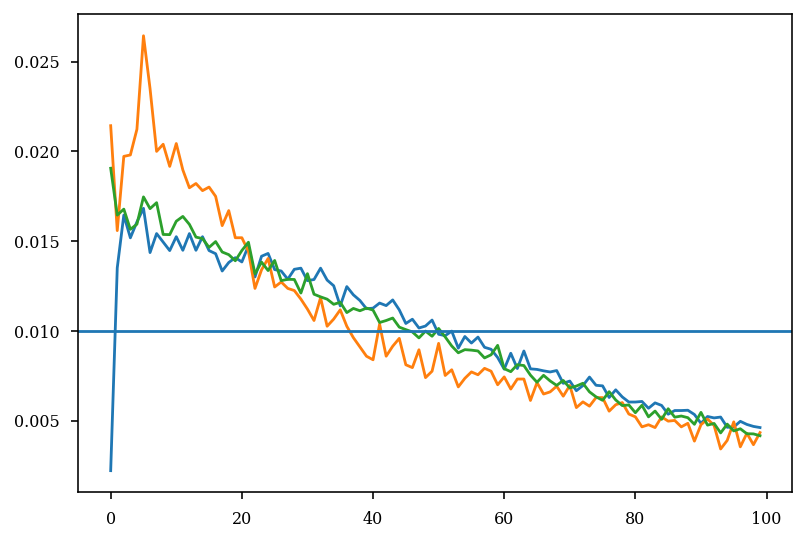

In [208]:
plt.plot(deep_isi)
plt.plot(sup_isi)
plt.plot(deep_sup_isi)
plt.axhline(0.01)

# example figures below

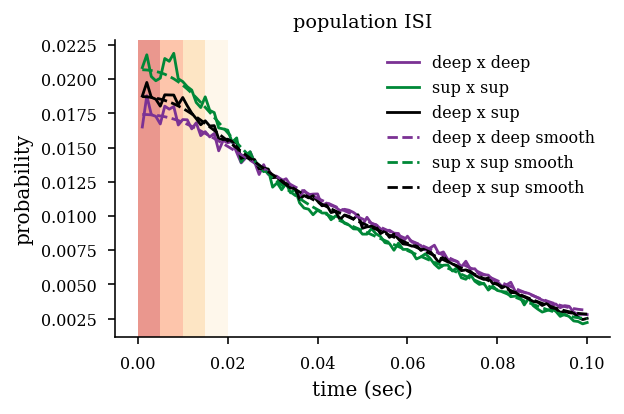

In [191]:
def bin_data(data,xmin=0,xmax=0.100,binwidth=0.001):
    bins = np.arange(xmin,xmax+binwidth,binwidth)

    hist, _ = np.histogram(data,bins=bins)
    hist = hist/hist.sum()
    return hist

bin_center = np.arange(0,0.100,0.001) + 0.001

plt.figure(figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 1)), edgecolor='k')
plt.plot(bin_center,bin_data(df.Deep),color="#7b3294",label="deep x deep")
plt.plot(bin_center,bin_data(df.Superficial),color="#008837",label="sup x sup") 
plt.plot(bin_center,bin_data(df.DeepSuperficial),color="black",label="deep x sup") 

ripple_cycle = 1/200
plt.axvspan(0,ripple_cycle, color='#d7301f', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle,ripple_cycle*2, color='#fc8d59', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*2,ripple_cycle*3, color='#fdcc8a', alpha=0.5, lw=0)
plt.axvspan(ripple_cycle*3,ripple_cycle*4, color='#fef0d9', alpha=0.5, lw=0)

# plt.plot(bin_center,bin_data(df.Deep_shuff),linestyle="--",color="#7b3294",label="deep x deep shuff")
# plt.plot(bin_center,bin_data(df.Superficial_shuff),linestyle="--",color="#008837",label="sup x sup shuff") 
# plt.plot(bin_center,bin_data(df.DeepSuperficial_shuff),linestyle="--",color="black",label="deep x sup shuff") 
sigma = 5
plt.plot(bin_center,gaussian_filter1d(bin_data(df.Deep), sigma),linestyle="--",color="#7b3294",label="deep x deep smooth")
plt.plot(bin_center,gaussian_filter1d(bin_data(df.Superficial), sigma),linestyle="--",color="#008837",label="sup x sup smooth") 
plt.plot(bin_center,gaussian_filter1d(bin_data(df.DeepSuperficial), sigma),linestyle="--",color="black",label="deep x sup smooth") 

plt.xlabel('time (sec)')
plt.ylabel('probability')
plt.title('population ISI')

# plt.xscale("log")

plt.legend(frameon=False)

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_gaussian_example.pdf'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'swr_seq_isi_gaussian_example.png'),dpi=300,bbox_inches='tight')


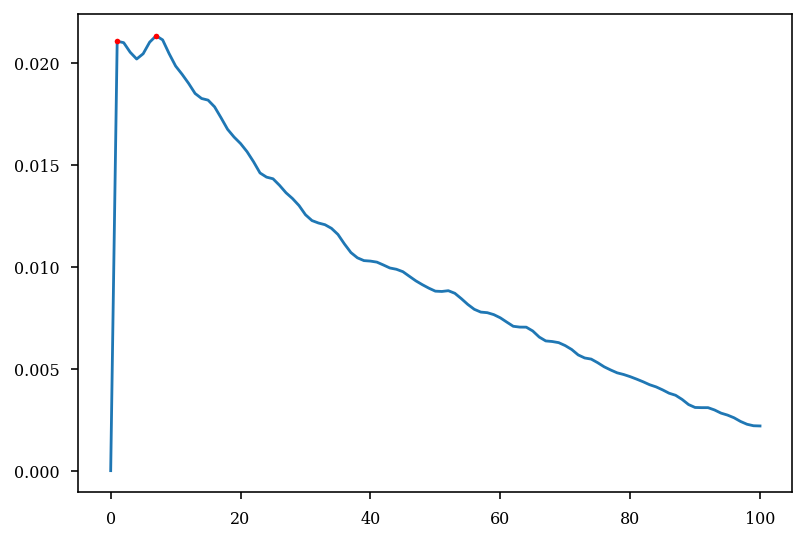

In [184]:
from scipy.signal import find_peaks

# x = bin_data(df.Superficial)
x = gaussian_filter1d(bin_data(df.Superficial), 1)
x = np.insert(x,0,0)

peaks, _ = find_peaks(x,prominence=np.std(x)/10)
plt.plot(x)
plt.plot(peaks, x[peaks],"r.")
plt.show()

In [185]:
peaks

array([1, 7], dtype=int64)

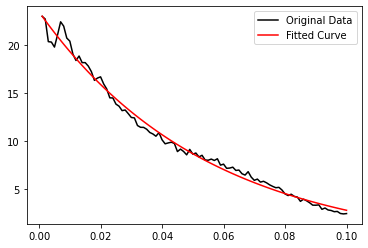

In [71]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, bin_center, bin_data(df.DeepSuperficial))

plt.figure()
plt.plot(bin_center, bin_data(df.DeepSuperficial), 'ko', label="Original Noised Data")
plt.plot(x, func(, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()